# Exploring Individual Factors Affecting PR Acceptability

## Imports & Load (Local) Dataset

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from utils import filter_top_n_for_cols

data_dir = "./data"
sub_dir = os.path.join(data_dir, "filtered")

pr_df = pd.read_csv(os.path.join(sub_dir, "pull_request.csv"))

pr_df.head()

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,...,total_churn,num_bot_users,num_human_users,num_total_users,num_comments,num_human_comments,num_bot_comments,num_reviews,num_human_reviews,num_bot_reviews
0,3264933329,2911,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,Claude_Code,108661493,weiliu1031,closed,2025-07-26T02:59:01Z,2025-07-29T07:01:20Z,...,396.0,0,2,2,2,2,0,0,0,0
1,3265640341,30,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,Claude_Code,7475,MSch,closed,2025-07-26T13:31:19Z,2025-07-26T13:37:22Z,...,407.0,1,1,2,0,0,0,2,1,1
2,3265709660,205,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,Claude_Code,80381,sugyan,closed,2025-07-26T14:07:22Z,2025-07-26T14:45:30Z,...,300.0,1,0,1,0,0,0,1,0,1
3,3214555104,16658,Add function signature breaking change detector,<details><summary>&#x1F6E0 DevTools &#x1F6E0</...,Claude_Code,17039389,harupy,closed,2025-07-09T05:35:26Z,2025-07-11T05:13:35Z,...,620.0,0,2,2,3,3,0,8,8,0
4,3214724259,5489,feat: add comprehensive test coverage for form...,## Summary\n\nThis PR enhances the forms plugi...,Claude_Code,82053242,wtfsayo,closed,2025-07-09T06:43:46Z,2025-07-09T06:44:02Z,...,1353.0,3,0,3,2,0,2,1,0,1


In [2]:
# Test Filtering
exclusion_col = ['num_comments']

cleaned_df = filter_top_n_for_cols(pr_df, exclusion_col, filter_percent=10)
print(f"Num. Rows in Cleaned DF = {len(cleaned_df)}")

PRs to exclude for num_comments: 1318
Total Rows to Filter: 1318
Num. Rows in Cleaned DF = 10644


In [2]:
print("Number of PRs:", pr_df.shape[0])
print("Columns in PR DataFrame:", pr_df.columns.tolist())

Number of PRs: 11962
Columns in PR DataFrame: ['id', 'number', 'title', 'body', 'agent', 'user_id', 'user', 'state', 'created_at', 'closed_at', 'merged_at', 'repo_id', 'repo_url', 'html_url', 'accepted', 'rejected', 'turnaround_time', 'related_issue', 'num_files_changed', 'touches_test_file', 'lines_added', 'lines_deleted', 'net_churn', 'total_churn', 'num_bot_users', 'num_human_users', 'num_total_users', 'num_comments', 'num_human_comments', 'num_bot_comments', 'num_reviews', 'num_human_reviews', 'num_bot_reviews']


In [3]:
accepted_prs = pr_df[pr_df['accepted'] == True]
print("Number of accepted PRs:", accepted_prs.shape[0])

rejected_prs = pr_df[pr_df['rejected'] == True]
print("Number of rejected PRs:", rejected_prs.shape[0])

Number of accepted PRs: 8141
Number of rejected PRs: 3821


## Repositories Analysis

In [ ]:
# Get top 10 repositories with most related issues (with details)
related_issues_by_repo = pr_df[pr_df['related_issue'] == True].groupby('repo_url').size().reset_index(name='related_issue_count')
related_issues_by_repo = related_issues_by_repo.sort_values('related_issue_count', ascending=False).head(10)

# Add total PR count and percentage
total_prs_by_repo = pr_df.groupby('repo_url').size().reset_index(name='total_prs')
related_issues_by_repo = related_issues_by_repo.merge(total_prs_by_repo, on='repo_url')
related_issues_by_repo['percentage'] = (related_issues_by_repo['related_issue_count'] / related_issues_by_repo['total_prs'] * 100).round(2)

related_issues_by_repo

,repo_url,related_issue_count,total_prs,percentage
0,https://api.github.com/repos/crewAIInc/crewAI,142,265,53.58
1,https://api.github.com/repos/dotnet/aspire,97,134,72.39
2,https://api.github.com/repos/microsoft/vscode,87,99,87.88
3,https://api.github.com/repos/mlflow/mlflow,79,85,92.94
4,https://api.github.com/repos/dotnet/docs,58,59,98.31
5,https://api.github.com/repos/microsoft/testfx,46,47,97.87
6,https://api.github.com/repos/celestiaorg/celes...,46,47,97.87
7,https://api.github.com/repos/remotion-dev/remo...,45,56,80.36
8,https://api.github.com/repos/hmislk/hmis,43,420,10.24
9,https://api.github.com/repos/dotnet/maui,41,44,93.18


In [5]:
top_10_repos_by_related_issues = related_issues_by_repo['repo_url'].tolist()
top_10_repos_by_related_issues

['https://api.github.com/repos/crewAIInc/crewAI',
 'https://api.github.com/repos/dotnet/aspire',
 'https://api.github.com/repos/microsoft/vscode',
 'https://api.github.com/repos/mlflow/mlflow',
 'https://api.github.com/repos/dotnet/docs',
 'https://api.github.com/repos/microsoft/testfx',
 'https://api.github.com/repos/celestiaorg/celestia-core',
 'https://api.github.com/repos/remotion-dev/remotion',
 'https://api.github.com/repos/hmislk/hmis',
 'https://api.github.com/repos/dotnet/maui']

## Related Issue

In [6]:
def analyze_boolean_factor(df, column_name, label_false='False', label_true='True', title_suffix=''):
    """
    Analyze acceptance rate based on a boolean column and perform chi-square test.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing PR data
    column_name : str
        Name of the boolean column to analyze
    label_false : str
        Label for False values in visualizations
    label_true : str
        Label for True values in visualizations
    title_suffix : str
        Additional text to add to plot titles
    
    Returns:
    --------
    dict : Contains chi2 statistic, p-value, and contingency data
    """
    from scipy.stats import chi2_contingency, fisher_exact
    
    # Create contingency table
    contingency_data = df.groupby(column_name).agg({
        'accepted': ['sum', 'count']
    }).reset_index()
    
    contingency_data.columns = [column_name, 'accepted_count', 'total_count']
    contingency_data['rejected_count'] = contingency_data['total_count'] - contingency_data['accepted_count']
    contingency_data['acceptance_rate'] = (contingency_data['accepted_count'] / contingency_data['total_count']) * 100
    
    print(f"Acceptance Rates by {column_name}:")
    print(contingency_data)
    print()
    
    # Perform Chi-square test
    contingency_table = pd.crosstab(df[column_name], df['accepted'])
    print("Contingency Table:")
    print(contingency_table)
    print()
    
    chi2, p_value_chi2, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"Chi-square p-value: {p_value_chi2:.20f}")
    print(f"Degrees of freedom: {dof}")
    
    # Check if any expected frequency is < 5
    min_expected = expected.min()
    print(f"Minimum expected frequency: {min_expected:.2f}")
    if min_expected < 5:
        print("WARNING: Chi-square may not be appropriate (expected frequency < 5)")
    print()
    
    # Perform Fisher's exact test
    # Convert contingency table to 2x2 array
    table_array = contingency_table.values
    odds_ratio, p_value_fisher = fisher_exact(table_array, alternative='two-sided')
    print(f"Fisher's exact test:")
    print(f"  Odds ratio: {odds_ratio:.4f}")
    print(f"  P-value: {p_value_fisher:.20f}")
    print(f"  Statistical significance: {'Yes (p < 0.005)' if p_value_fisher < 0.005 else 'No (p >= 0.005)'}")
    print(f"\nRecommended test: {'Fisher (small sample)' if min_expected < 5 else 'Chi-square (sufficient sample)'}")
    print()
    
    # Visualize the comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart of acceptance rates
    axes[0].bar([label_false, label_true], 
                contingency_data['acceptance_rate'],
                color=['#FF6B6B', '#4ECDC4'],
                edgecolor='black')
    axes[0].set_ylabel('Acceptance Rate (%)')
    axes[0].set_title(f'PR Acceptance Rate: {title_suffix or column_name}')
    axes[0].set_ylim(0, 100)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Add n and percentage labels on bars
    for idx, row in contingency_data.iterrows():
        label = label_false if row[column_name] == False else label_true
        axes[0].text(idx, row['acceptance_rate'] + 2, 
                     f"{row['acceptance_rate']:.1f}%\n(n={int(row['total_count'])})",
                     ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Stacked bar chart showing counts
    axes[1].bar([label_false, label_true],
                contingency_data['accepted_count'],
                label='Accepted',
                color='#4ECDC4',
                edgecolor='black')
    axes[1].bar([label_false, label_true],
                contingency_data['rejected_count'],
                bottom=contingency_data['accepted_count'],
                label='Rejected',
                color='#FF6B6B',
                edgecolor='black')
    axes[1].set_ylabel('Number of PRs')
    axes[1].set_title(f'PR Outcomes: {title_suffix or column_name}')
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'chi2': chi2,
        'p_value_chi2': p_value_chi2,
        'dof': dof,
        'odds_ratio': odds_ratio,
        'p_value_fisher': p_value_fisher,
        'min_expected_freq': min_expected,
        'contingency_data': contingency_data
    }

### Overall

Acceptance Rates by related_issue:
   related_issue  accepted_count  total_count  rejected_count  acceptance_rate
0          False            6067         8754            2687        69.305460
1           True            2074         3208            1134        64.650873

Contingency Table:
accepted       False  True 
related_issue              
False           2687   6067
True            1134   2074

Chi-square statistic: 23.1830
Chi-square p-value: 0.00000147296924850910
Degrees of freedom: 1
Minimum expected frequency: 1024.73

Fisher's exact test:
  Odds ratio: 0.8100
  P-value: 0.00000155187616848674
  Statistical significance: Yes (p < 0.005)

Recommended test: Chi-square (sufficient sample)



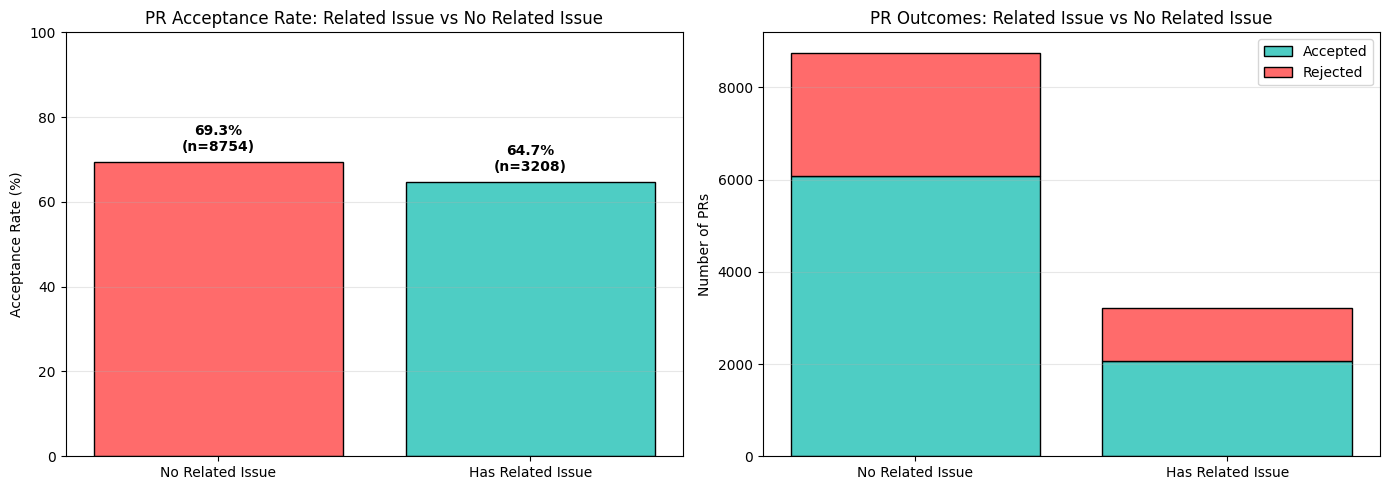

In [7]:
pr_df.columns

pr_df['related_issue'].value_counts()

analyze_boolean_factor(pr_df, 'related_issue', 
                      label_false='No Related Issue', 
                      label_true='Has Related Issue',
                      title_suffix='Related Issue vs No Related Issue')
None

### Per repo for top 10 repos by PR with related issue count

Analyzing repository: https://api.github.com/repos/crewAIInc/crewAI
Acceptance Rates by related_issue:
   related_issue  accepted_count  total_count  rejected_count  acceptance_rate
0          False              25          123              98        20.325203
1           True              17          142             125        11.971831

Contingency Table:
accepted       False  True 
related_issue              
False             98     25
True             125     17

Chi-square statistic: 2.8504
Chi-square p-value: 0.09134860867522830163
Degrees of freedom: 1
Minimum expected frequency: 19.49

Fisher's exact test:
  Odds ratio: 0.5331
  P-value: 0.06642491718020331060
  Statistical significance: No (p >= 0.005)

Recommended test: Chi-square (sufficient sample)



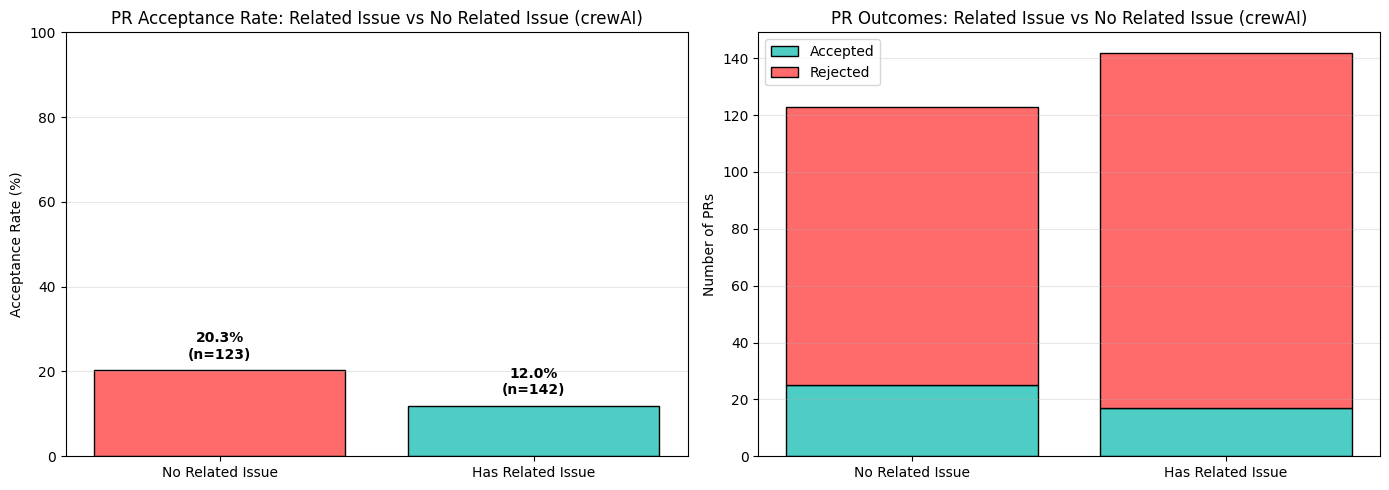



Analyzing repository: https://api.github.com/repos/dotnet/aspire
Acceptance Rates by related_issue:
   related_issue  accepted_count  total_count  rejected_count  acceptance_rate
0          False              31           37               6        83.783784
1           True              74           97              23        76.288660

Contingency Table:
accepted       False  True 
related_issue              
False              6     31
True              23     74

Chi-square statistic: 0.5003
Chi-square p-value: 0.47936009811695134974
Degrees of freedom: 1
Minimum expected frequency: 8.01

Fisher's exact test:
  Odds ratio: 0.6227
  P-value: 0.48210969795859309750
  Statistical significance: No (p >= 0.005)

Recommended test: Chi-square (sufficient sample)



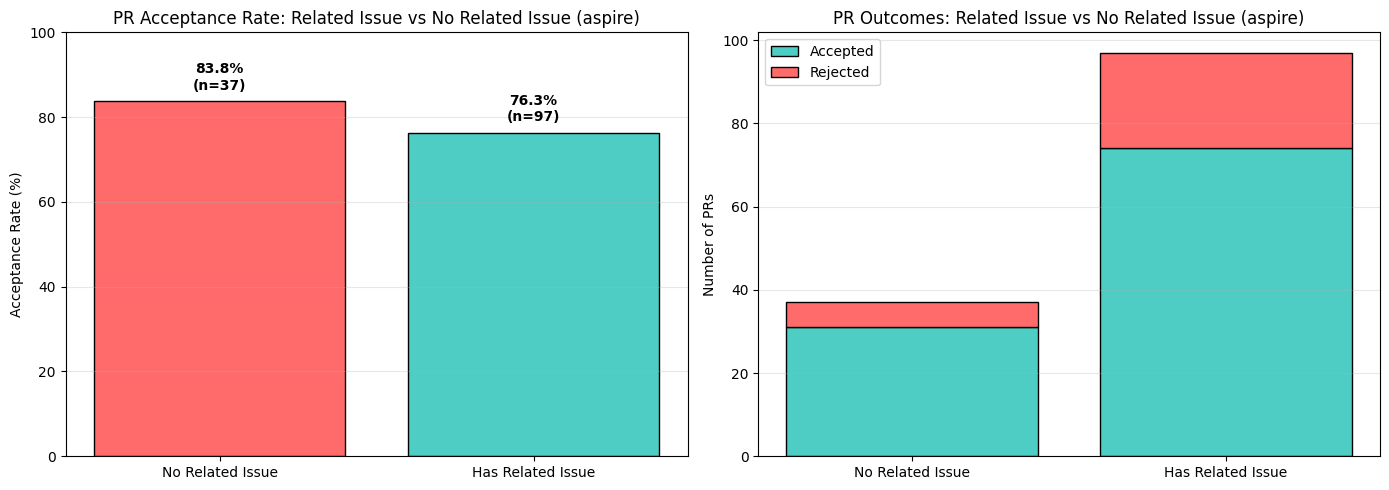



Analyzing repository: https://api.github.com/repos/microsoft/vscode
Acceptance Rates by related_issue:
   related_issue  accepted_count  total_count  rejected_count  acceptance_rate
0          False               5           12               7        41.666667
1           True              53           87              34        60.919540

Contingency Table:
accepted       False  True 
related_issue              
False              7      5
True              34     53

Chi-square statistic: 0.9153
Chi-square p-value: 0.33872060922369245928
Degrees of freedom: 1
Minimum expected frequency: 4.97

Fisher's exact test:
  Odds ratio: 2.1824
  P-value: 0.22655632683864737609
  Statistical significance: No (p >= 0.005)

Recommended test: Fisher (small sample)



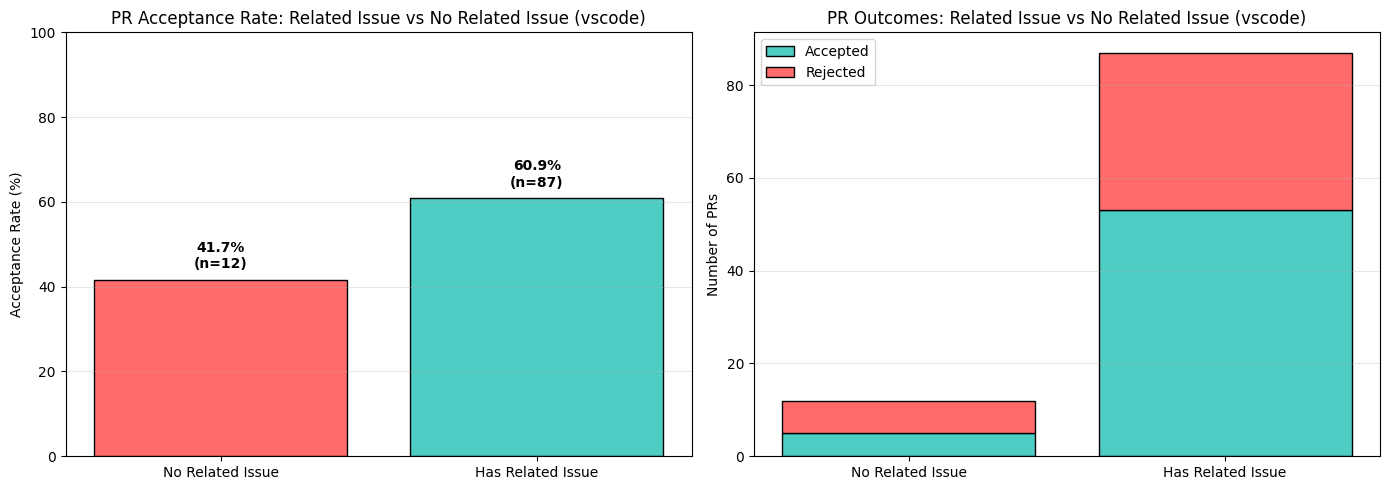



Analyzing repository: https://api.github.com/repos/mlflow/mlflow
Acceptance Rates by related_issue:
   related_issue  accepted_count  total_count  rejected_count  acceptance_rate
0          False               5            6               1        83.333333
1           True              70           79               9        88.607595

Contingency Table:
accepted       False  True 
related_issue              
False              1      5
True               9     70

Chi-square statistic: 0.0000
Chi-square p-value: 1.00000000000000000000
Degrees of freedom: 1
Minimum expected frequency: 0.71

Fisher's exact test:
  Odds ratio: 1.5556
  P-value: 0.53959549340355217328
  Statistical significance: No (p >= 0.005)

Recommended test: Fisher (small sample)



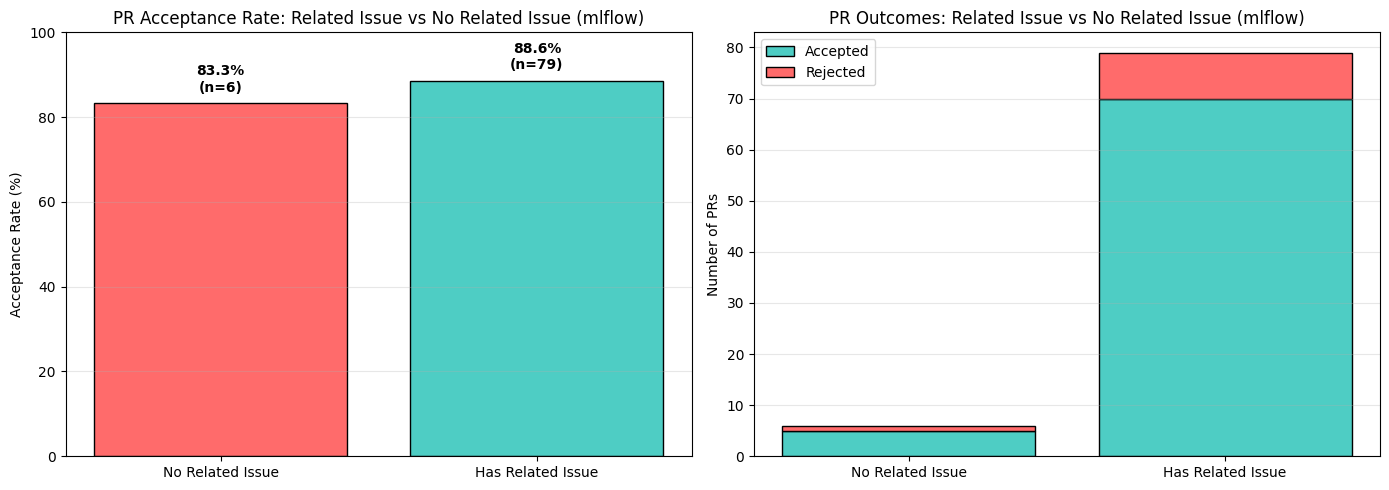



Analyzing repository: https://api.github.com/repos/dotnet/docs
Acceptance Rates by related_issue:
   related_issue  accepted_count  total_count  rejected_count  acceptance_rate
0          False               1            1               0        100.00000
1           True              53           58               5         91.37931

Contingency Table:
accepted       False  True 
related_issue              
False              0      1
True               5     53

Chi-square statistic: 0.0000
Chi-square p-value: 1.00000000000000000000
Degrees of freedom: 1
Minimum expected frequency: 0.08

Fisher's exact test:
  Odds ratio: 0.0000
  P-value: 1.00000000000000000000
  Statistical significance: No (p >= 0.005)

Recommended test: Fisher (small sample)



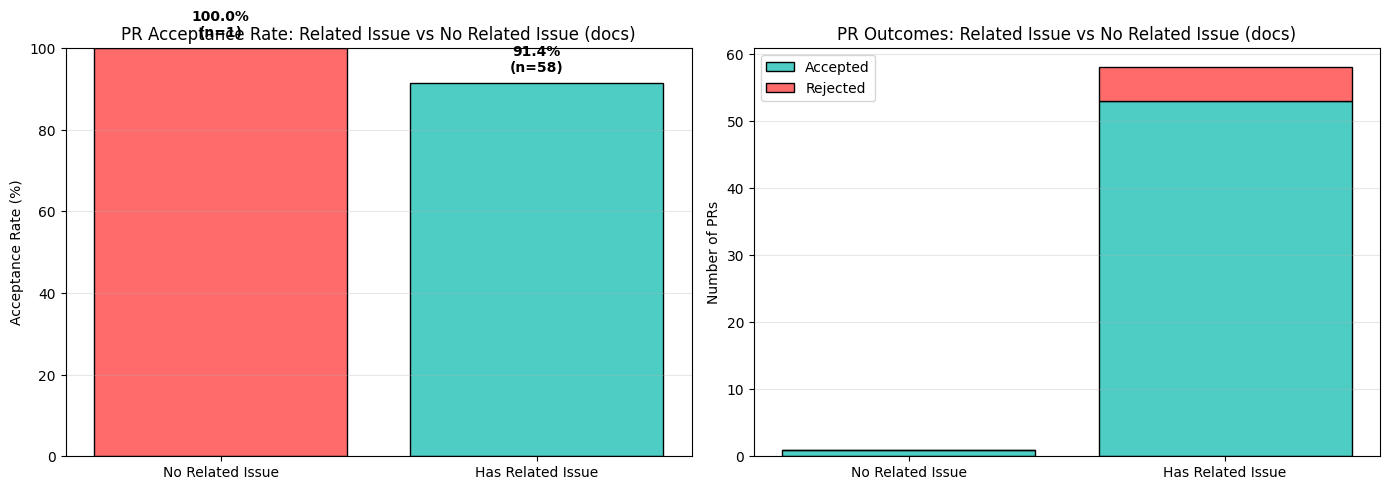



Analyzing repository: https://api.github.com/repos/microsoft/testfx
Acceptance Rates by related_issue:
   related_issue  accepted_count  total_count  rejected_count  acceptance_rate
0          False               1            1               0       100.000000
1           True              34           46              12        73.913043

Contingency Table:
accepted       False  True 
related_issue              
False              0      1
True              12     34

Chi-square statistic: 0.0000
Chi-square p-value: 1.00000000000000000000
Degrees of freedom: 1
Minimum expected frequency: 0.26

Fisher's exact test:
  Odds ratio: 0.0000
  P-value: 1.00000000000000000000
  Statistical significance: No (p >= 0.005)

Recommended test: Fisher (small sample)



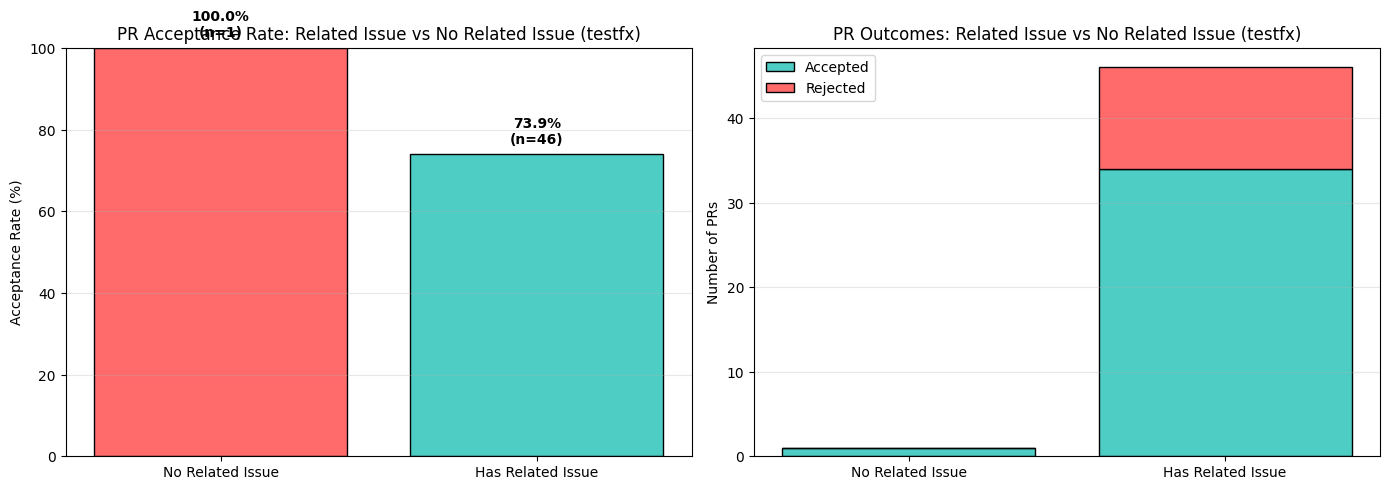



Analyzing repository: https://api.github.com/repos/celestiaorg/celestia-core
Acceptance Rates by related_issue:
   related_issue  accepted_count  total_count  rejected_count  acceptance_rate
0          False               0            1               1         0.000000
1           True              39           46               7        84.782609

Contingency Table:
accepted       False  True 
related_issue              
False              1      0
True               7     39

Chi-square statistic: 0.7868
Chi-square p-value: 0.37507802689891900361
Degrees of freedom: 1
Minimum expected frequency: 0.17

Fisher's exact test:
  Odds ratio: inf
  P-value: 0.17021276595744683213
  Statistical significance: No (p >= 0.005)

Recommended test: Fisher (small sample)



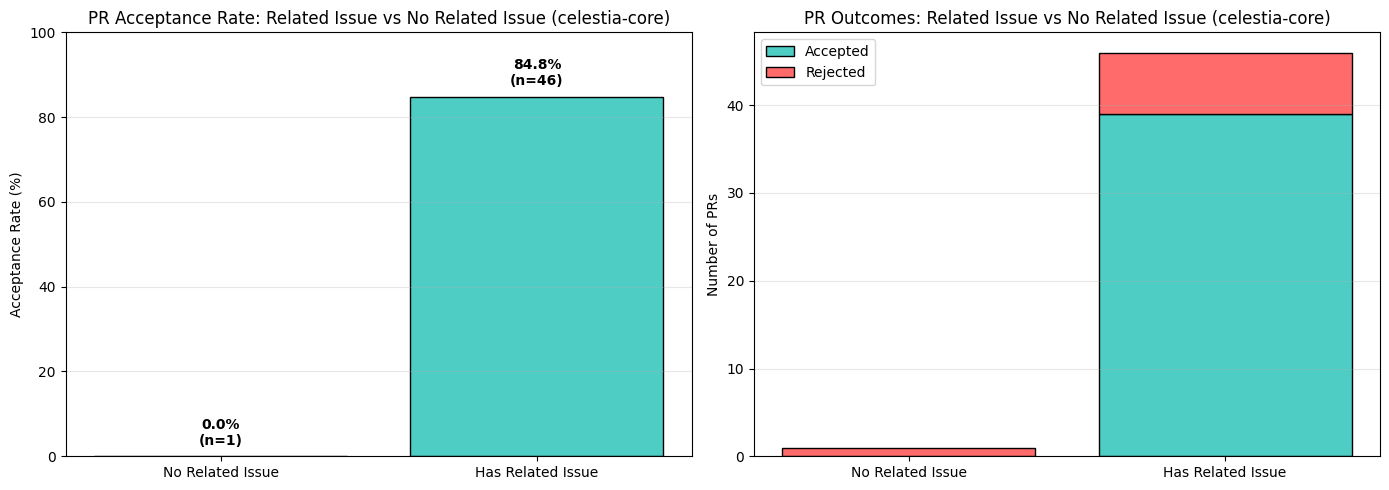



Analyzing repository: https://api.github.com/repos/remotion-dev/remotion
Acceptance Rates by related_issue:
   related_issue  accepted_count  total_count  rejected_count  acceptance_rate
0          False               9           11               2        81.818182
1           True              31           45              14        68.888889

Contingency Table:
accepted       False  True 
related_issue              
False              2      9
True              14     31

Chi-square statistic: 0.2291
Chi-square p-value: 0.63219872645631114416
Degrees of freedom: 1
Minimum expected frequency: 3.14

Fisher's exact test:
  Odds ratio: 0.4921
  P-value: 0.48289619026009156233
  Statistical significance: No (p >= 0.005)

Recommended test: Fisher (small sample)



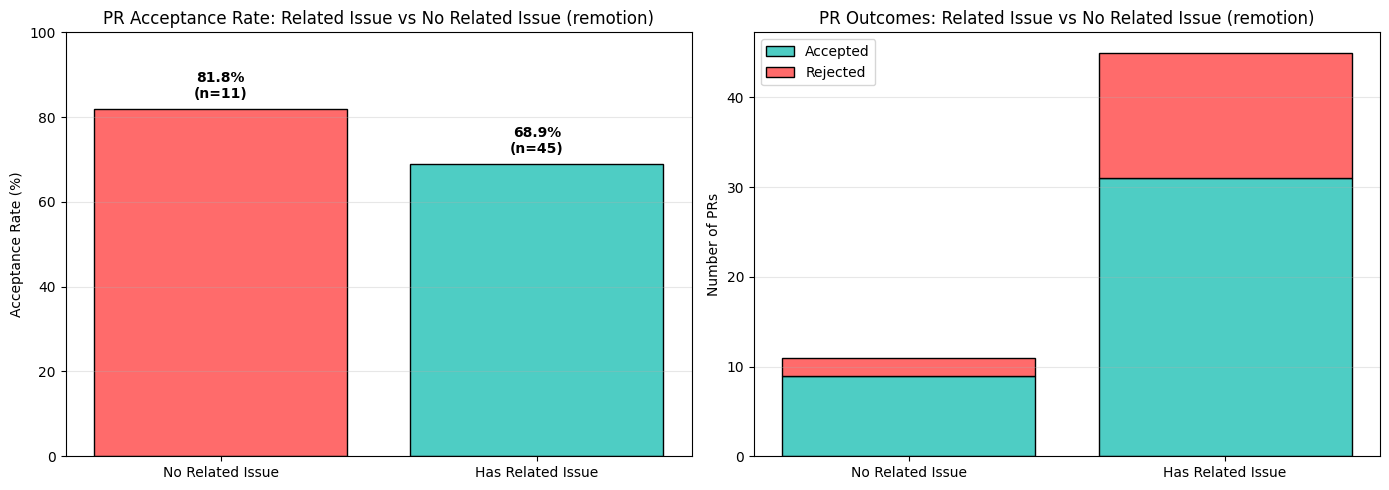



Analyzing repository: https://api.github.com/repos/hmislk/hmis
Acceptance Rates by related_issue:
   related_issue  accepted_count  total_count  rejected_count  acceptance_rate
0          False             368          377               9        97.612732
1           True              42           43               1        97.674419

Contingency Table:
accepted       False  True 
related_issue              
False              9    368
True               1     42

Chi-square statistic: 0.0000
Chi-square p-value: 1.00000000000000000000
Degrees of freedom: 1
Minimum expected frequency: 1.02

Fisher's exact test:
  Odds ratio: 1.0272
  P-value: 1.00000000000000000000
  Statistical significance: No (p >= 0.005)

Recommended test: Fisher (small sample)



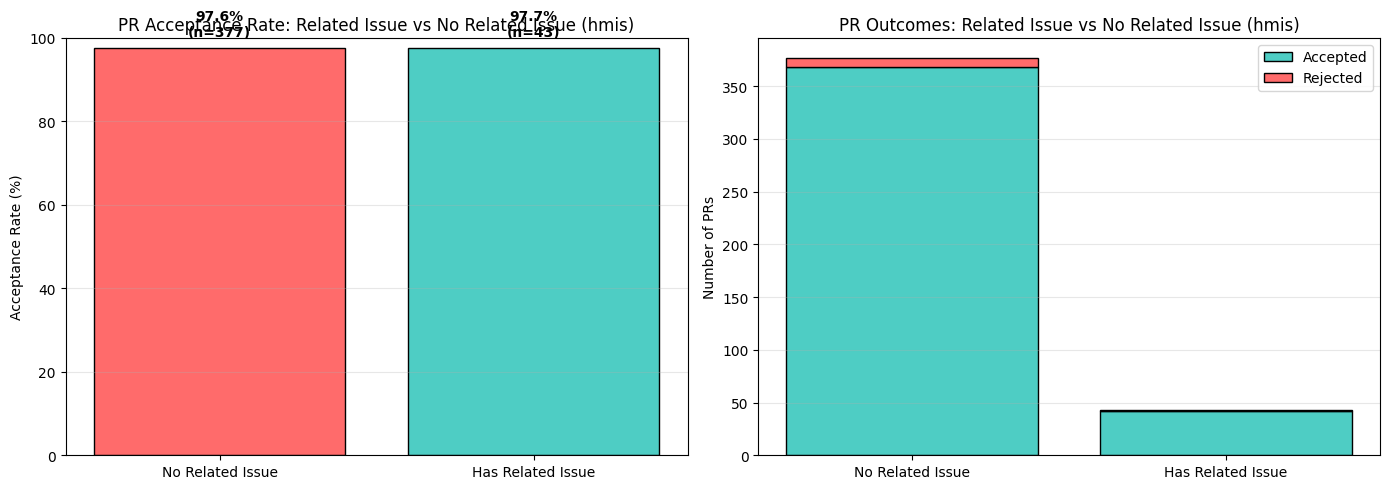



Analyzing repository: https://api.github.com/repos/dotnet/maui
Acceptance Rates by related_issue:
   related_issue  accepted_count  total_count  rejected_count  acceptance_rate
0          False               2            3               1        66.666667
1           True              15           41              26        36.585366

Contingency Table:
accepted       False  True 
related_issue              
False              1      2
True              26     15

Chi-square statistic: 0.1754
Chi-square p-value: 0.67539611632586993295
Degrees of freedom: 1
Minimum expected frequency: 1.16

Fisher's exact test:
  Odds ratio: 0.2885
  P-value: 0.54945635759589239733
  Statistical significance: No (p >= 0.005)

Recommended test: Fisher (small sample)



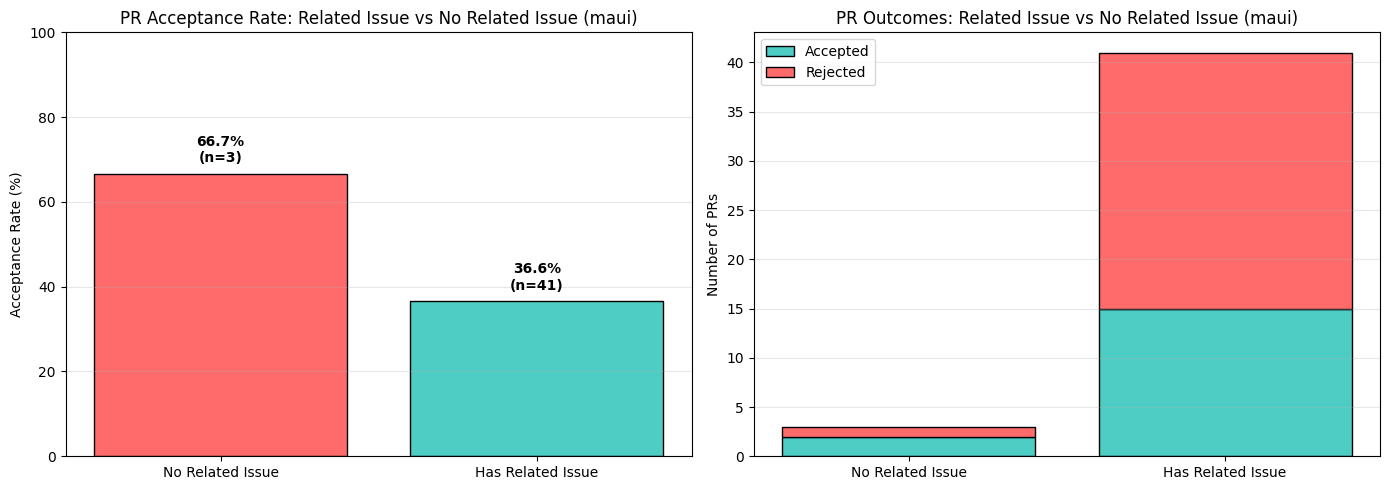

In [8]:
for repo in top_10_repos_by_related_issues:
    print(f"Analyzing repository: {repo}")
    repo_df = pr_df[pr_df['repo_url'] == repo]
    analyze_boolean_factor(repo_df, 'related_issue', 
                          label_false='No Related Issue', 
                          label_true='Has Related Issue',
                          title_suffix=f'Related Issue vs No Related Issue ({repo.split("/")[-1]})')
    print("\n" + "="*80 + "\n")

## Number of Files Touched

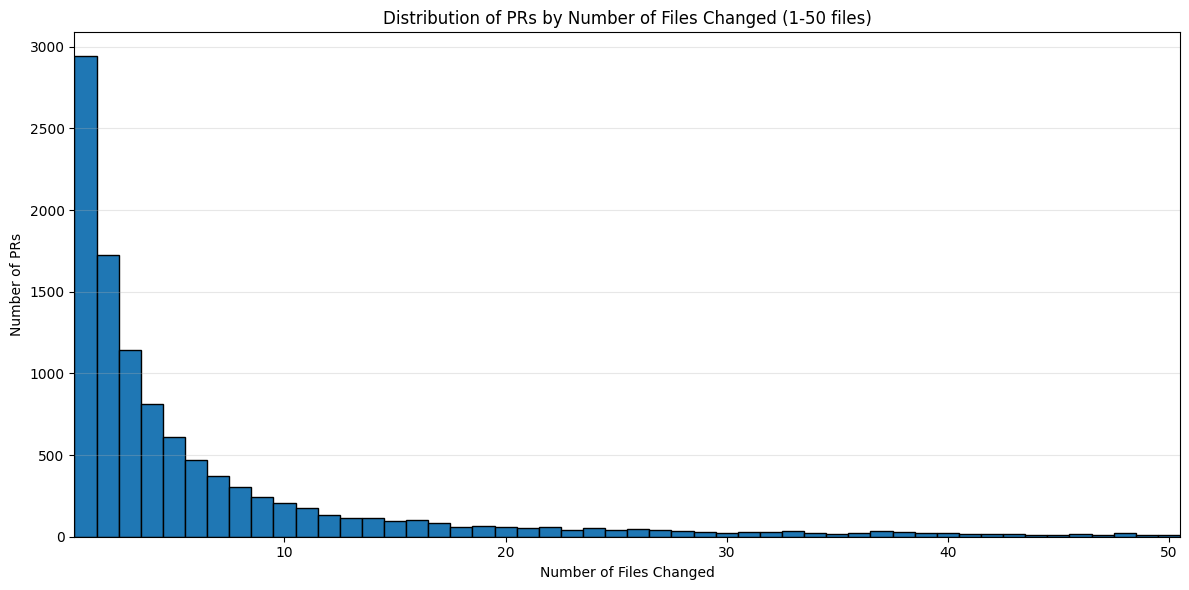

In [9]:
pr_df['num_files_changed'].max()

pr_df[pr_df['num_files_changed'] == pr_df['num_files_changed'].max()]

# Create histogram of number of PRs by files changed (1-50 files)
file_counts = pr_df['num_files_changed'].dropna()
file_counts = file_counts[file_counts <= 50]

plt.figure(figsize=(12, 6))
plt.hist(file_counts, bins=range(1, 52), edgecolor='black', align='left')
plt.xlabel('Number of Files Changed')
plt.ylabel('Number of PRs')
plt.title('Distribution of PRs by Number of Files Changed (1-50 files)')
plt.xlim(0.5, 50.5)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

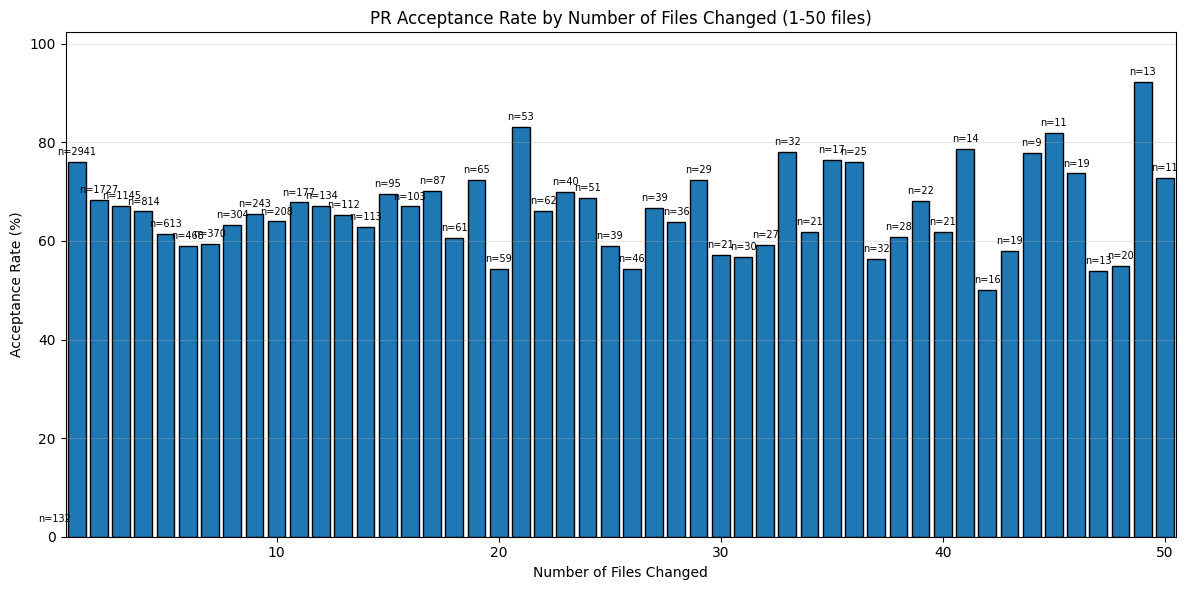

In [10]:
# Create histogram of acceptance rate by files changed (1-50 files)
file_data = pr_df[pr_df['num_files_changed'] <= 50].groupby('num_files_changed').agg({
    'accepted': ['sum', 'count']
}).reset_index()

file_data.columns = ['num_files_changed', 'accepted_count', 'total_count']
file_data['acceptance_rate'] = (file_data['accepted_count'] / file_data['total_count']) * 100

plt.figure(figsize=(12, 6))
bars = plt.bar(file_data['num_files_changed'], file_data['acceptance_rate'], 
               edgecolor='black', width=0.8)

# Add n labels on each bar
for idx, row in file_data.iterrows():
    plt.text(row['num_files_changed'], row['acceptance_rate'] + 1, 
             f"n={int(row['total_count'])}", 
             ha='center', va='bottom', fontsize=7)

plt.xlabel('Number of Files Changed')
plt.ylabel('Acceptance Rate (%)')
plt.title('PR Acceptance Rate by Number of Files Changed (1-50 files)')
plt.xlim(0.5, 50.5)
plt.ylim(0, max(file_data['acceptance_rate']) + 10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## PR Touches Test Files

Acceptance Rates by touches_test_file:
   touches_test_file  accepted_count  total_count  rejected_count  \
0              False            5059         7139            2080   
1               True            3082         4823            1741   

   acceptance_rate  
0        70.864267  
1        63.902136  

Contingency Table:
accepted           False  True 
touches_test_file              
False               2080   5059
True                1741   3082

Chi-square statistic: 63.8584
Chi-square p-value: 0.00000000000000133690
Degrees of freedom: 1
Minimum expected frequency: 1540.60

Fisher's exact test:
  Odds ratio: 0.7278
  P-value: 0.00000000000000145373
  Statistical significance: Yes (p < 0.005)

Recommended test: Chi-square (sufficient sample)



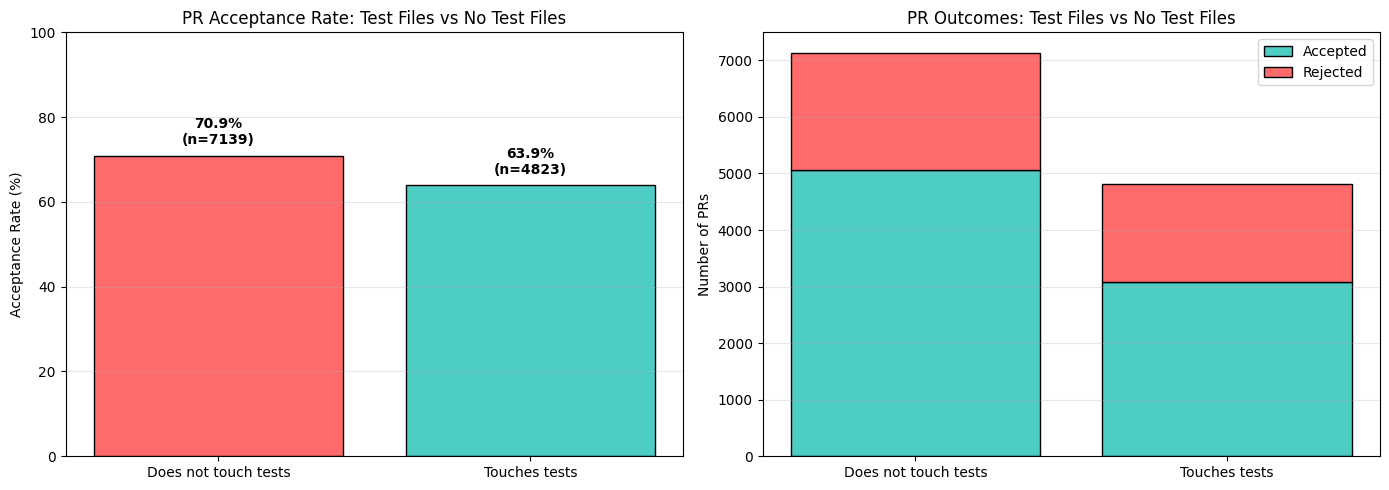

In [11]:
analyze_boolean_factor(pr_df, 'touches_test_file', 
                      label_false='Does not touch tests', 
                      label_true='Touches tests',
                      title_suffix='Test Files vs No Test Files')
None

### Per repo for top 10 repos by PRs with touching tests

In [12]:
pr_df.columns

Index(['id', 'number', 'title', 'body', 'agent', 'user_id', 'user', 'state',
       'created_at', 'closed_at', 'merged_at', 'repo_id', 'repo_url',
       'html_url', 'accepted', 'rejected', 'turnaround_time', 'related_issue',
       'num_files_changed', 'touches_test_file', 'lines_added',
       'lines_deleted', 'net_churn', 'total_churn', 'num_bot_users',
       'num_human_users', 'num_total_users', 'num_comments',
       'num_human_comments', 'num_bot_comments', 'num_reviews',
       'num_human_reviews', 'num_bot_reviews'],
      dtype='object')

In [13]:
# Get top 10 repositories with most related issues (with details)
touches_tests_by_repo = pr_df[pr_df['touches_test_file'] == True].groupby('repo_url').size().reset_index(name='touches_test_count')
touches_tests_by_repo = touches_tests_by_repo.sort_values('touches_test_count', ascending=False).head(10)

# Optionally add total PR count and percentage
total_prs_by_repo = pr_df.groupby('repo_url').size().reset_index(name='total_prs')
touches_tests_by_repo = touches_tests_by_repo.merge(total_prs_by_repo, on='repo_url')
touches_tests_by_repo['percentage'] = (touches_tests_by_repo['touches_test_count'] / touches_tests_by_repo['total_prs'] * 100).round(2)

touches_tests_by_repo

,repo_url,touches_test_count,total_prs,percentage
0,https://api.github.com/repos/crewAIInc/crewAI,246,265,92.83
1,https://api.github.com/repos/liam-hq/liam,125,343,36.44
2,https://api.github.com/repos/dotnet/aspire,113,134,84.33
3,https://api.github.com/repos/oven-sh/bun,101,117,86.32
4,https://api.github.com/repos/calcom/cal.com,79,209,37.80
5,https://api.github.com/repos/antiwork/flexile,72,156,46.15
6,https://api.github.com/repos/prebid/Prebid.js,70,87,80.46
7,https://api.github.com/repos/airbytehq/airbyte,67,218,30.73
8,https://api.github.com/repos/promptfoo/promptfoo,66,104,63.46
9,https://api.github.com/repos/antiwork/helper,54,168,32.14


In [14]:
top_10_repos_by_touches_tests = touches_tests_by_repo['repo_url'].tolist()
top_10_repos_by_touches_tests

['https://api.github.com/repos/crewAIInc/crewAI',
 'https://api.github.com/repos/liam-hq/liam',
 'https://api.github.com/repos/dotnet/aspire',
 'https://api.github.com/repos/oven-sh/bun',
 'https://api.github.com/repos/calcom/cal.com',
 'https://api.github.com/repos/antiwork/flexile',
 'https://api.github.com/repos/prebid/Prebid.js',
 'https://api.github.com/repos/airbytehq/airbyte',
 'https://api.github.com/repos/promptfoo/promptfoo',
 'https://api.github.com/repos/antiwork/helper']

Analyzing repository: https://api.github.com/repos/crewAIInc/crewAI
Acceptance Rates by touches_test_file:
   touches_test_file  accepted_count  total_count  rejected_count  \
0              False              10           19               9   
1               True              32          246             214   

   acceptance_rate  
0        52.631579  
1        13.008130  

Contingency Table:
accepted           False  True 
touches_test_file              
False                  9     10
True                 214     32

Chi-square statistic: 17.8981
Chi-square p-value: 0.00002330514274784779
Degrees of freedom: 1
Minimum expected frequency: 3.01

Fisher's exact test:
  Odds ratio: 0.1346
  P-value: 0.00011399245076646027
  Statistical significance: Yes (p < 0.005)

Recommended test: Fisher (small sample)



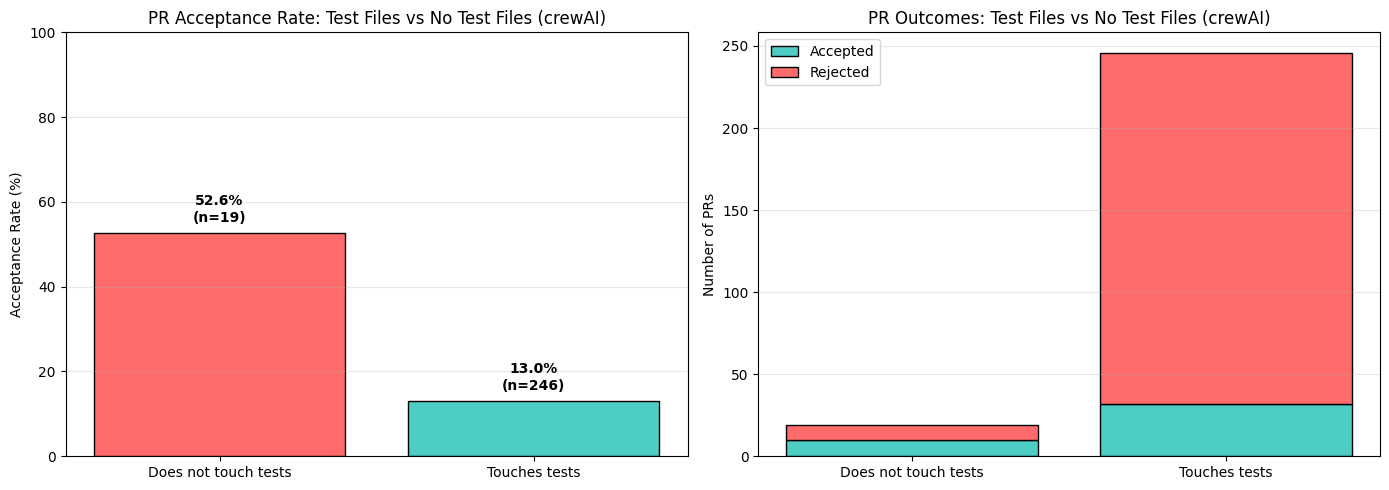



Analyzing repository: https://api.github.com/repos/liam-hq/liam
Acceptance Rates by touches_test_file:
   touches_test_file  accepted_count  total_count  rejected_count  \
0              False             168          218              50   
1               True              88          125              37   

   acceptance_rate  
0         77.06422  
1         70.40000  

Contingency Table:
accepted           False  True 
touches_test_file              
False                 50    168
True                  37     88

Chi-square statistic: 1.5284
Chi-square p-value: 0.21635319941304545499
Degrees of freedom: 1
Minimum expected frequency: 31.71

Fisher's exact test:
  Odds ratio: 0.7079
  P-value: 0.19751908465435819018
  Statistical significance: No (p >= 0.005)

Recommended test: Chi-square (sufficient sample)



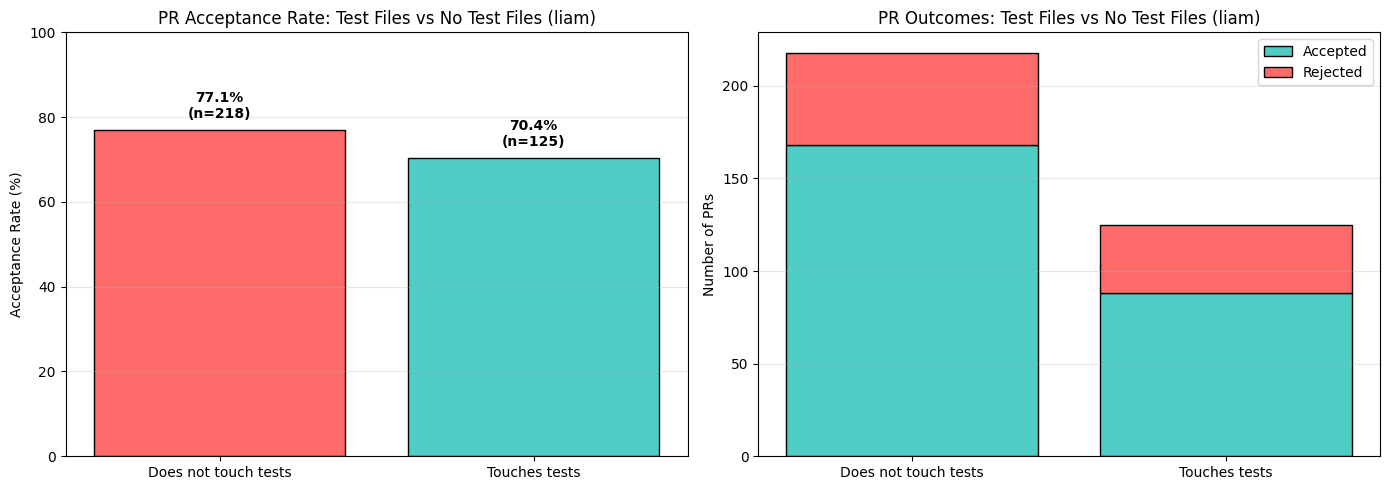



Analyzing repository: https://api.github.com/repos/dotnet/aspire
Acceptance Rates by touches_test_file:
   touches_test_file  accepted_count  total_count  rejected_count  \
0              False              16           21               5   
1               True              89          113              24   

   acceptance_rate  
0        76.190476  
1        78.761062  

Contingency Table:
accepted           False  True 
touches_test_file              
False                  5     16
True                  24     89

Chi-square statistic: 0.0000
Chi-square p-value: 1.00000000000000000000
Degrees of freedom: 1
Minimum expected frequency: 4.54

Fisher's exact test:
  Odds ratio: 1.1589
  P-value: 0.77731992803448091145
  Statistical significance: No (p >= 0.005)

Recommended test: Fisher (small sample)



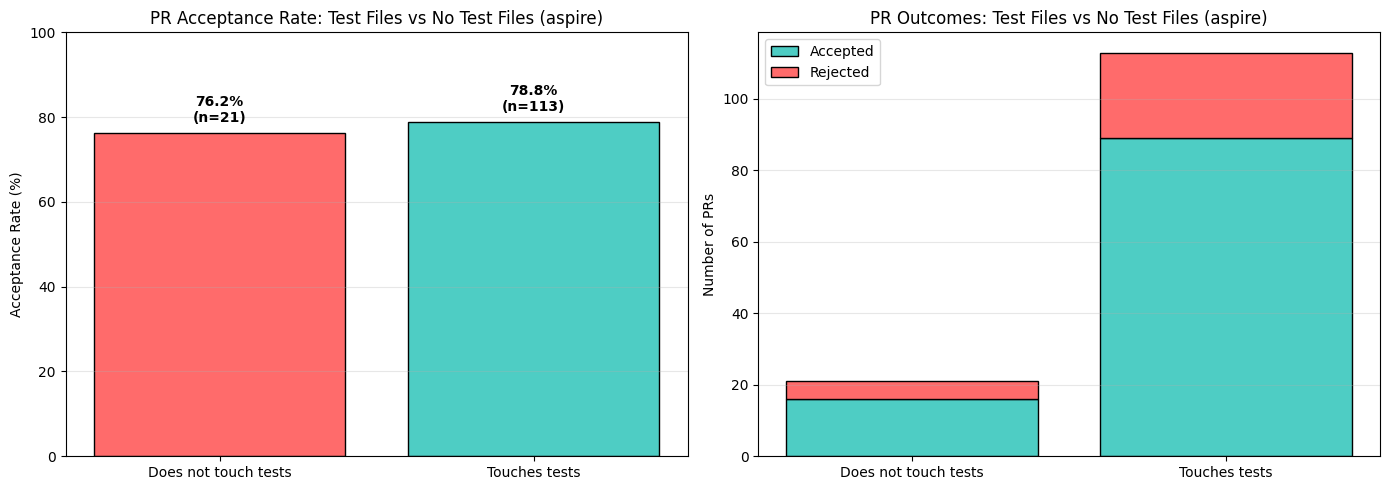



Analyzing repository: https://api.github.com/repos/oven-sh/bun
Acceptance Rates by touches_test_file:
   touches_test_file  accepted_count  total_count  rejected_count  \
0              False               5           16              11   
1               True              32          101              69   

   acceptance_rate  
0        31.250000  
1        31.683168  

Contingency Table:
accepted           False  True 
touches_test_file              
False                 11      5
True                  69     32

Chi-square statistic: 0.0000
Chi-square p-value: 1.00000000000000000000
Degrees of freedom: 1
Minimum expected frequency: 5.06

Fisher's exact test:
  Odds ratio: 1.0203
  P-value: 1.00000000000000000000
  Statistical significance: No (p >= 0.005)

Recommended test: Chi-square (sufficient sample)



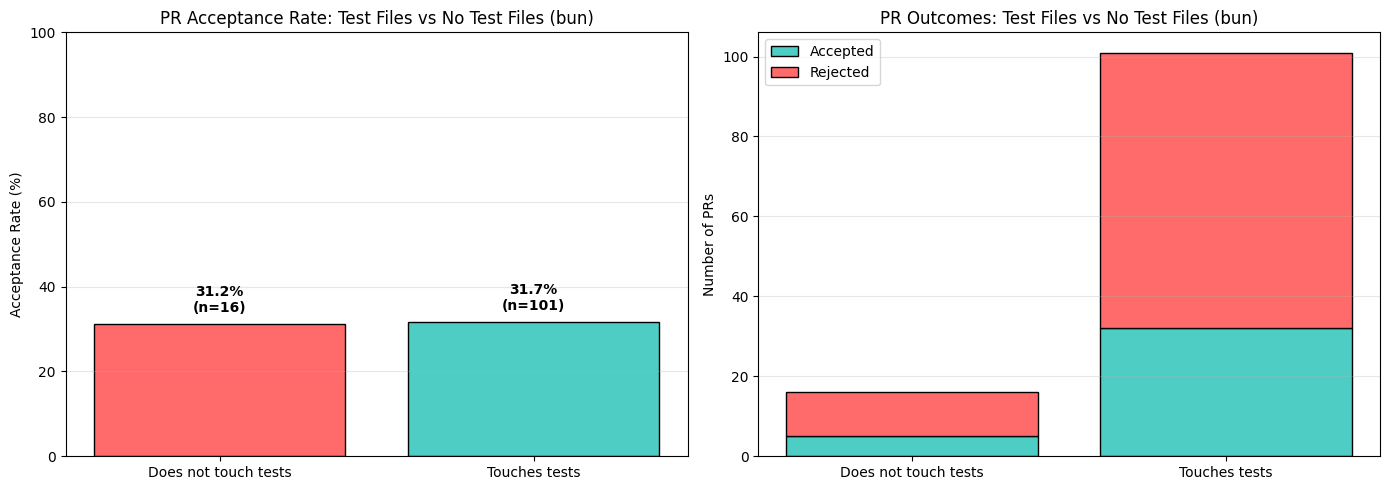



Analyzing repository: https://api.github.com/repos/calcom/cal.com
Acceptance Rates by touches_test_file:
   touches_test_file  accepted_count  total_count  rejected_count  \
0              False              36          130              94   
1               True              43           79              36   

   acceptance_rate  
0        27.692308  
1        54.430380  

Contingency Table:
accepted           False  True 
touches_test_file              
False                 94     36
True                  36     43

Chi-square statistic: 13.8263
Chi-square p-value: 0.00020050759784415715
Degrees of freedom: 1
Minimum expected frequency: 29.86

Fisher's exact test:
  Odds ratio: 3.1188
  P-value: 0.00013394797817976552
  Statistical significance: Yes (p < 0.005)

Recommended test: Chi-square (sufficient sample)



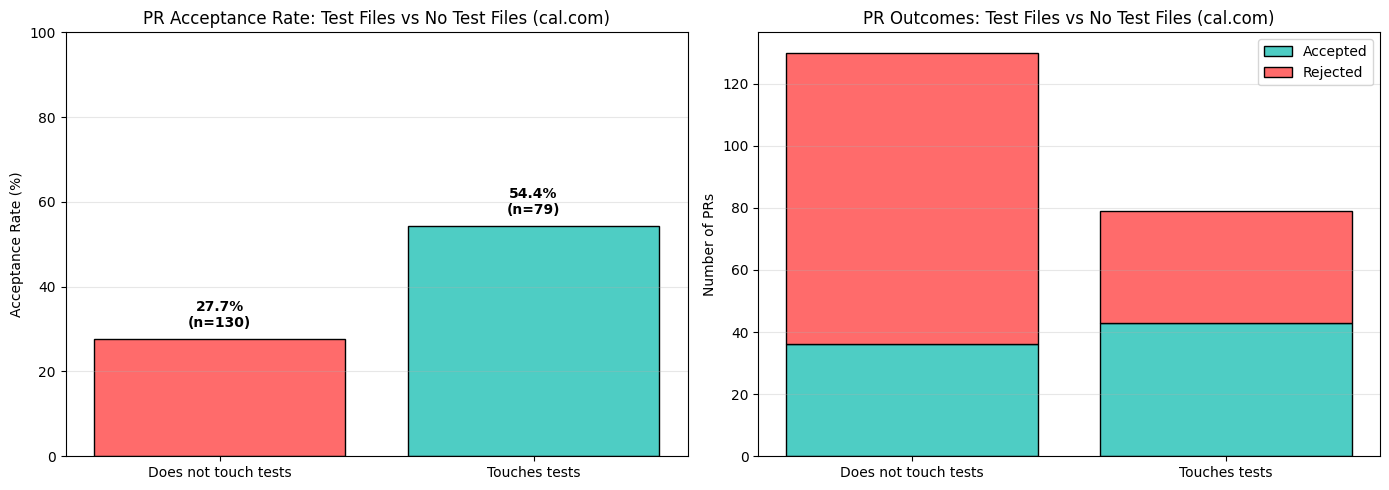



Analyzing repository: https://api.github.com/repos/antiwork/flexile
Acceptance Rates by touches_test_file:
   touches_test_file  accepted_count  total_count  rejected_count  \
0              False              71           84              13   
1               True              50           72              22   

   acceptance_rate  
0        84.523810  
1        69.444444  

Contingency Table:
accepted           False  True 
touches_test_file              
False                 13     71
True                  22     50

Chi-square statistic: 4.2363
Chi-square p-value: 0.03956722012676099770
Degrees of freedom: 1
Minimum expected frequency: 16.15

Fisher's exact test:
  Odds ratio: 0.4161
  P-value: 0.03364116082112926509
  Statistical significance: No (p >= 0.005)

Recommended test: Chi-square (sufficient sample)



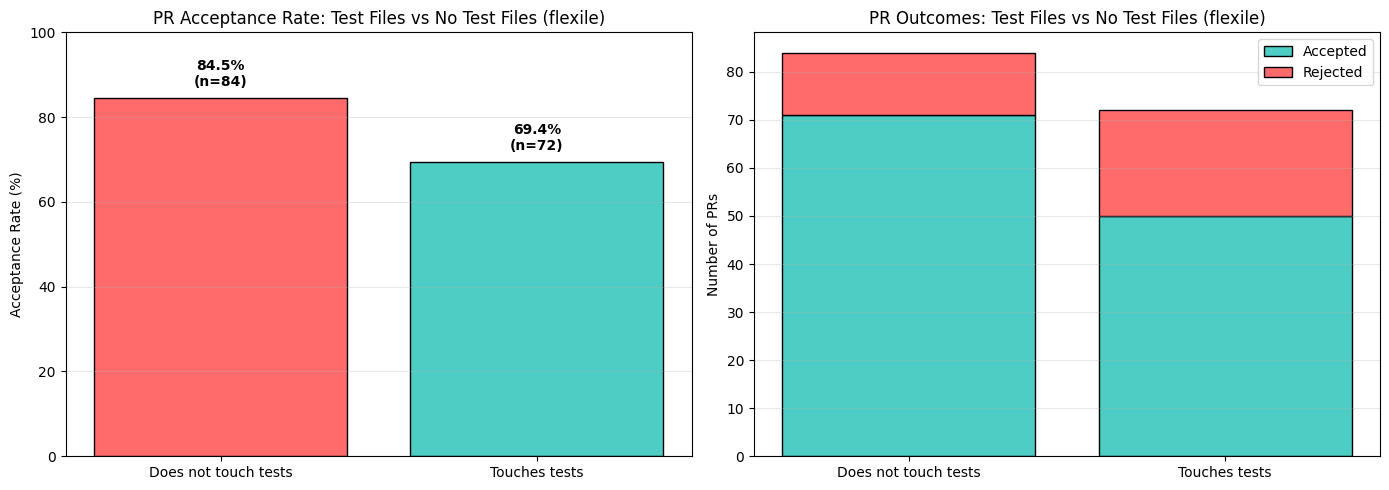



Analyzing repository: https://api.github.com/repos/prebid/Prebid.js
Acceptance Rates by touches_test_file:
   touches_test_file  accepted_count  total_count  rejected_count  \
0              False              16           17               1   
1               True              65           70               5   

   acceptance_rate  
0        94.117647  
1        92.857143  

Contingency Table:
accepted           False  True 
touches_test_file              
False                  1     16
True                   5     65

Chi-square statistic: 0.0000
Chi-square p-value: 1.00000000000000000000
Degrees of freedom: 1
Minimum expected frequency: 1.17

Fisher's exact test:
  Odds ratio: 0.8125
  P-value: 1.00000000000000000000
  Statistical significance: No (p >= 0.005)

Recommended test: Fisher (small sample)



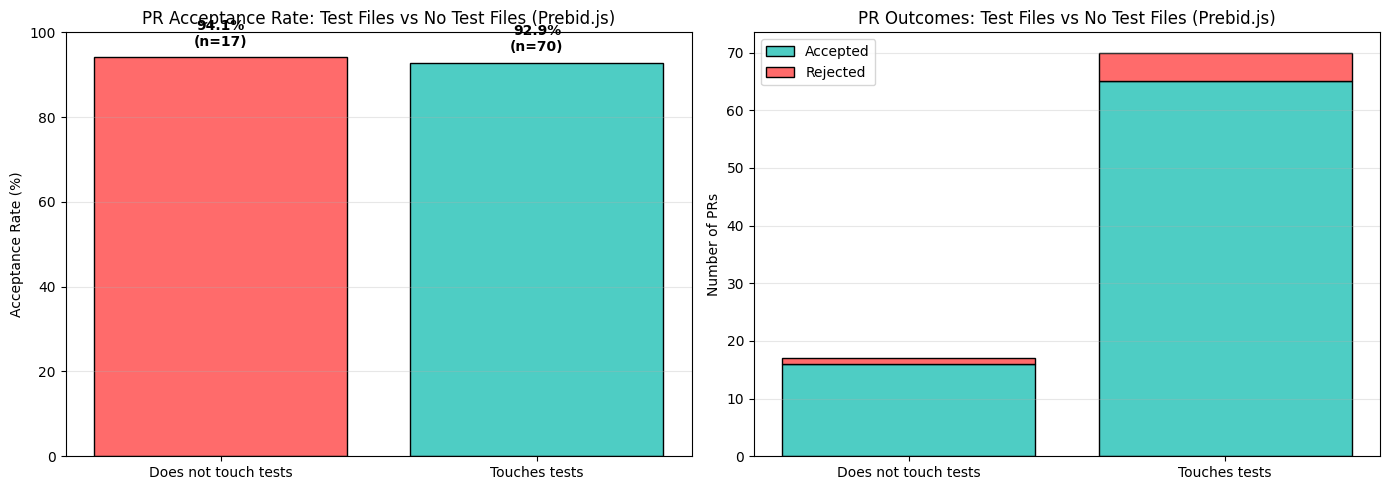



Analyzing repository: https://api.github.com/repos/airbytehq/airbyte
Acceptance Rates by touches_test_file:
   touches_test_file  accepted_count  total_count  rejected_count  \
0              False              78          151              73   
1               True              31           67              36   

   acceptance_rate  
0        51.655629  
1        46.268657  

Contingency Table:
accepted           False  True 
touches_test_file              
False                 73     78
True                  36     31

Chi-square statistic: 0.3448
Chi-square p-value: 0.55709089601347461240
Degrees of freedom: 1
Minimum expected frequency: 33.50

Fisher's exact test:
  Odds ratio: 0.8059
  P-value: 0.55726795108546833823
  Statistical significance: No (p >= 0.005)

Recommended test: Chi-square (sufficient sample)



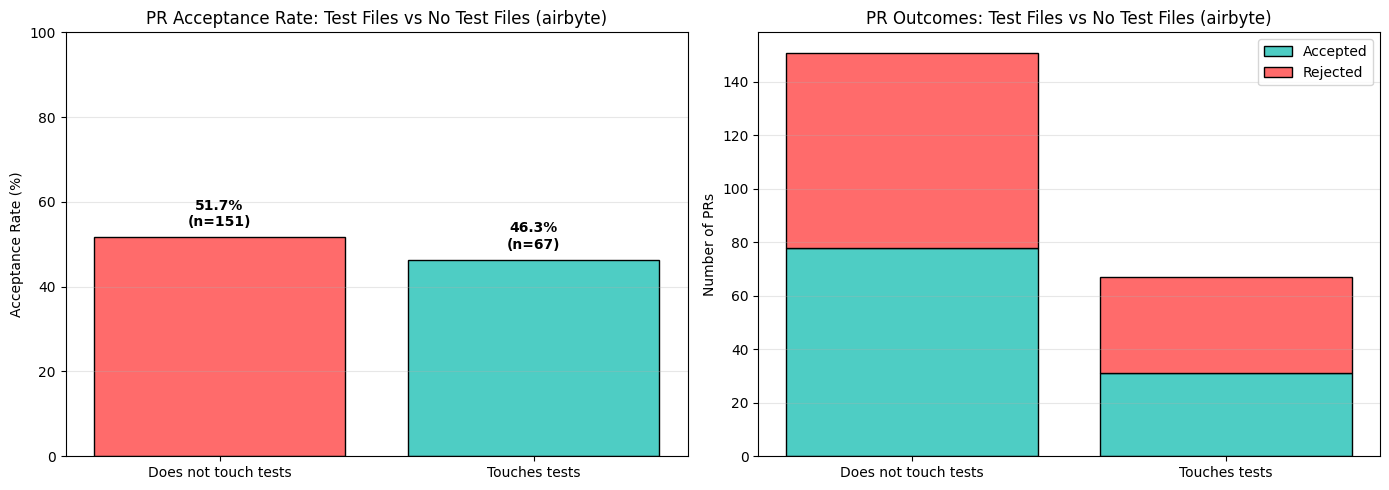



Analyzing repository: https://api.github.com/repos/promptfoo/promptfoo
Acceptance Rates by touches_test_file:
   touches_test_file  accepted_count  total_count  rejected_count  \
0              False              30           38               8   
1               True              55           66              11   

   acceptance_rate  
0        78.947368  
1        83.333333  

Contingency Table:
accepted           False  True 
touches_test_file              
False                  8     30
True                  11     55

Chi-square statistic: 0.0864
Chi-square p-value: 0.76883687905569231269
Degrees of freedom: 1
Minimum expected frequency: 6.94

Fisher's exact test:
  Odds ratio: 1.3333
  P-value: 0.60543705628283728259
  Statistical significance: No (p >= 0.005)

Recommended test: Chi-square (sufficient sample)



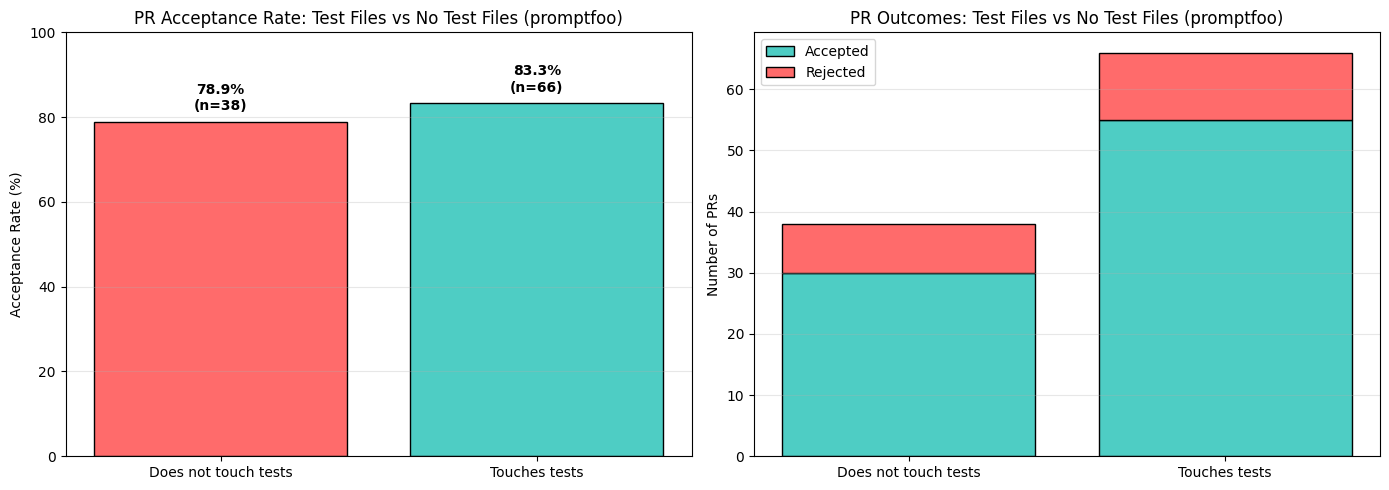



Analyzing repository: https://api.github.com/repos/antiwork/helper
Acceptance Rates by touches_test_file:
   touches_test_file  accepted_count  total_count  rejected_count  \
0              False              93          114              21   
1               True              46           54               8   

   acceptance_rate  
0        81.578947  
1        85.185185  

Contingency Table:
accepted           False  True 
touches_test_file              
False                 21     93
True                   8     46

Chi-square statistic: 0.1289
Chi-square p-value: 0.71954340340904399120
Degrees of freedom: 1
Minimum expected frequency: 9.32

Fisher's exact test:
  Odds ratio: 1.2984
  P-value: 0.66487473718499767728
  Statistical significance: No (p >= 0.005)

Recommended test: Chi-square (sufficient sample)



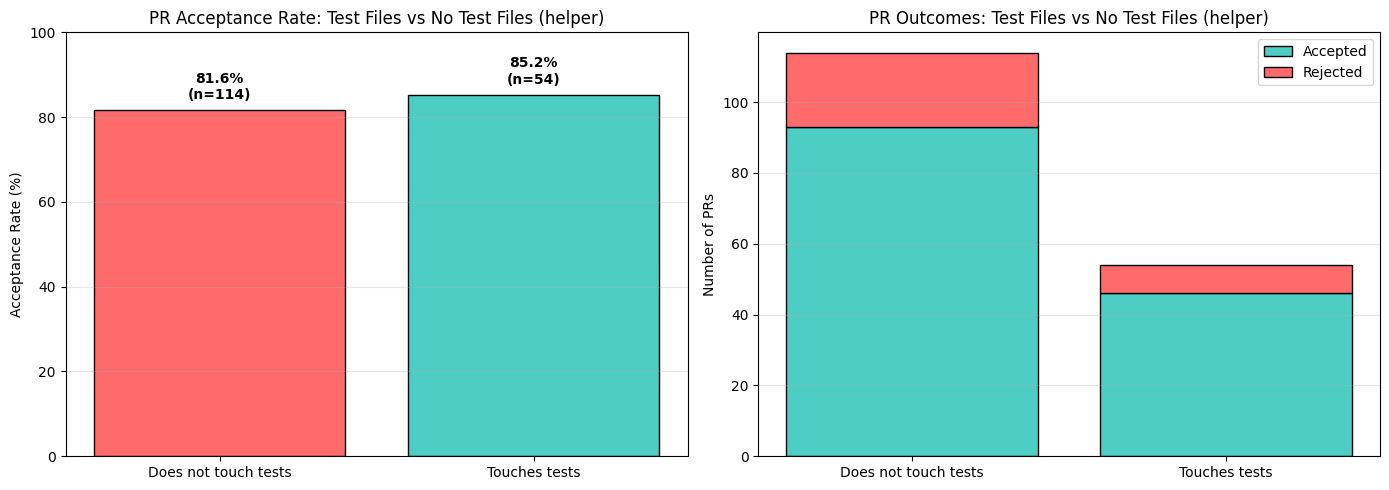

In [15]:
for repo in top_10_repos_by_touches_tests:
    print(f"Analyzing repository: {repo}")
    repo_df = pr_df[pr_df['repo_url'] == repo]
    analyze_boolean_factor(repo_df, 'touches_test_file', 
                          label_false='Does not touch tests', 
                          label_true='Touches tests',
                          title_suffix=f'Test Files vs No Test Files ({repo.split("/")[-1]})')
    print("\n" + "="*80 + "\n")

## Churn Metrics

In [16]:
pr_df.columns

pr_df['total_churn'].describe()

count    1.194900e+04
mean     3.037537e+03
std      2.403505e+04
min      0.000000e+00
25%      2.600000e+01
50%      1.260000e+02
75%      6.300000e+02
max      1.451946e+06
Name: total_churn, dtype: float64

### Total Churn

## Comments & Reviews

In [17]:
pr_df.columns

Index(['id', 'number', 'title', 'body', 'agent', 'user_id', 'user', 'state',
       'created_at', 'closed_at', 'merged_at', 'repo_id', 'repo_url',
       'html_url', 'accepted', 'rejected', 'turnaround_time', 'related_issue',
       'num_files_changed', 'touches_test_file', 'lines_added',
       'lines_deleted', 'net_churn', 'total_churn', 'num_bot_users',
       'num_human_users', 'num_total_users', 'num_comments',
       'num_human_comments', 'num_bot_comments', 'num_reviews',
       'num_human_reviews', 'num_bot_reviews'],
      dtype='object')

In [19]:
pr_df['has_human_review'] = pr_df['num_human_reviews'] > 0

pr_df['has_human_review'].value_counts()

has_human_review
False    6701
True     5261
Name: count, dtype: int64